In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal
import numpy as np
import cv2

#IDEA PRINCIPAL 1:

Construir un programa capaz de recibir una foto de un ECG completo con sus 12 derivaciones, que extraiga la señal correspondiente a la segunda derivación, la segmente por latidos y nos de los latidos segmentados. De ahí podemos normalizar y pasarle los latidos al modelo entrenado con imágenes o procesar los latidos para usar el modelo numérico.

In [3]:
#Cargamos distintas imágenes de ECG obtenidas de la red y páginas específicas.

import matplotlib.pyplot as plt
import cv2
img1 = cv2.imread("/content/drive/MyDrive/ECG.IMG/ecg1.png")
img2= cv2.imread("/content/drive/MyDrive/ECG.IMG/ecg2.png")
img3= cv2.imread("/content/drive/MyDrive/ECG.IMG/ecg3.png")
img4= cv2.imread("/content/drive/MyDrive/ECG.IMG/ecg4.png")
img5 =cv2.imread( "/content/drive/MyDrive/ECG.IMG/ecg5.png")
img6 =cv2.imread( "/content/drive/MyDrive/ECG.IMG/ecg6.png")
img7binari = cv2.imread("/content/result3.png")
arritmia_S ="/content/drive/MyDrive/Arrtimias/ritmo_sinusal_lento/Captura desde 2023-04-25 13-36-39.png"
arritmia_V= "/content/drive/MyDrive/Arrtimias/arritmia_ventricular/Captura desde 2023-04-25 13-40-00.png"
arritmia_F = "/content/drive/MyDrive/Arrtimias/Fibrilación auricular/Captura desde 2023-04-25 13-45-30.png"
arritmia_Q = "/content/drive/MyDrive/Arrtimias/Bloqueo_de_rama/Captura desde 2023-04-25 13-48-59.png"

In [4]:
a_tipo_F=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_F.jpeg")
a_tipo_Q=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_Q.jpeg")
a_tipo_S=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_S.jpeg")
a_tipo_V=("/content/drive/MyDrive/arritmias_final/Arritmia_tipo_V.jpeg")
normal =("/content/drive/MyDrive/arritmias_final/Normal.jpeg")
arritmia_F_V = "/content/vector_001(1).bmp"
arritmia_F_V2 = "/content/WhatsApp Image 2023-05-06 at 20.10.31.jpeg"
arritmia_F_V3 = "/content/vector_002.bmp"
arritmia_F_V3 = "/content/vector_003.bmp"
arritmia_F_V4 = "/content/vector_004.bmp"






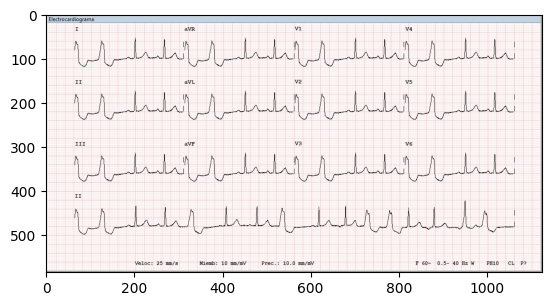

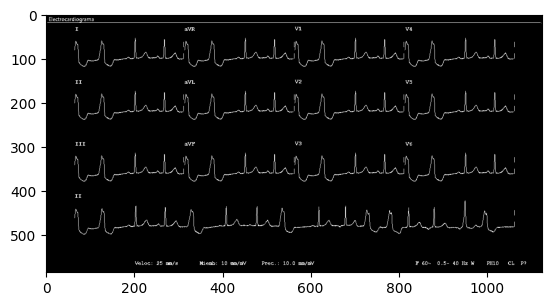

In [5]:
from PIL import Image, ImageOps

# Cargar la imagen
img = Image.open(a_tipo_F)

plt.imshow(img, cmap='gray')
plt.show()
# Convertir la imagen a escala de grises
# Convertir la imagen a escala de grises
img_grayscale = img.convert('L')

# Aplicar un filtro de umbral
threshold_value = 150
img_binary = img_grayscale.point(lambda x: 0 if x < threshold_value else 255, '1')

# Convertir la imagen binaria a un arreglo de numpy de tipo uint8
img_binary = np.array(img_binary).astype(np.uint8)

# Invertir los colores de la imagen binaria
img_inverted = Image.fromarray(255 - img_binary)
img_inverted.save('ecg1_inverted.png')
# Visualizar la imagen
plt.imshow(img_inverted, cmap='gray')
plt.show()

Observamos que conseguimos ajustar el filtro para separar el fondo de la señal. Sin embargo no generaliza con todos los ECG de la misma manera, en algunos deja demasiado ruido de la rejilla del fondo al ser de un rosa más fuerte, y por otro lado si el ecg tiene dobles quizas no se puede procesar correctamente. Tras completar el preprocesado y el programa se ejecute por completo procederemos a mejorar las excepciones para optimizar un preprocesado genérico.

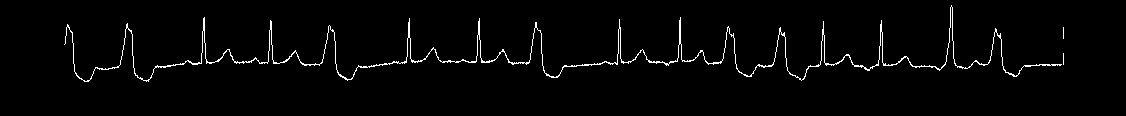

In [6]:
# obtenemos las dimensiones de la imagen
image = cv2.imread("/content/ecg1_inverted.png", 0)
img_norm = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

height, width = image.shape[:2]

# especificamos las coordenadas de píxeles para la sección inferior de la imagen
x = 0
y = int(height * 0.715)  # ajusta este valor para recortar una sección diferente de la imagen
w = width
h = int(height * 0.2)

# recortamos la sección de la imagen utilizando las coordenadas de píxeles especificadas
seccion_inferior = img_norm[y:y+h, x:x+w]
cv2.imwrite('result3.png', seccion_inferior)

# mostramos la sección recortada de la imagen
cv2_imshow(seccion_inferior)
cv2.waitKey(0)
cv2.destroyAllWindows()


Aqui nos encontramos con otro problema similar. Algunos Ecg son mas largos o anchos que otros. La solución la hemos visto en el front obligando al cliente a ajusta la imagen a determinada medida antes de hacer la foto. Siendo así conseguiriamos extraer siempre la misma parte de la imagen, en este caso la ultima señal que es la que nos interesa.

####Estre tramo de código fue creado para aquellas imágenes donde el trazo esta cortado, tras una pruebas com`probé que algunos ecg perdían parte de la señal, con el metodo fillPoly expandía el trazo juntando el contorno y dilantanto la señal. Como las imagenes usadas para este ejemplo no tienen esa excepción, omitimos este código por ahora.

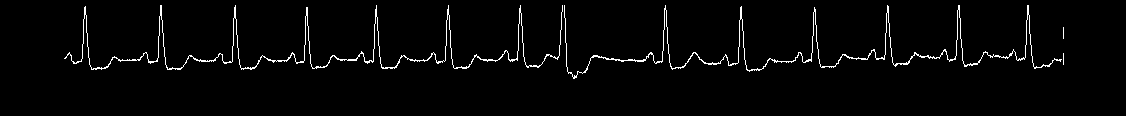

In [112]:
# Encontrar el contorno del trazo
contours, hierarchy = cv2.findContours(seccion_inferior, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Crear una imagen en blanco del mismo tamaño que la imagen binaria del trazo
filled_trazo = np.zeros_like(seccion_inferior)

# Dibujar el contorno del trazo en la imagen en blanco
cv2.drawContours(filled_trazo, contours, -1, (255, 255, 255), thickness=-1)
# Expandir el contorno del trazo con cv2.dilate
kernel = np.ones((1, 1), np.uint8)
dilated_trazo = cv2.dilate(filled_trazo, kernel)

# Rellenar el interior del contorno del trazo
cv2.fillPoly(dilated_trazo, pts=[contours[0]], color=(255, 255, 255))

cv2.imwrite('result3.png', dilated_trazo)

cv2_imshow(dilated_trazo)
cv2.waitKey(0)
cv2.destroyAllWindows()

###PRUEBA NÚMERO 1, Señal sin filtros.

Convertimos la imagen binaria a vector pero el modelo no consigue procesarla adecuadamente.[texto del enlace](https://)

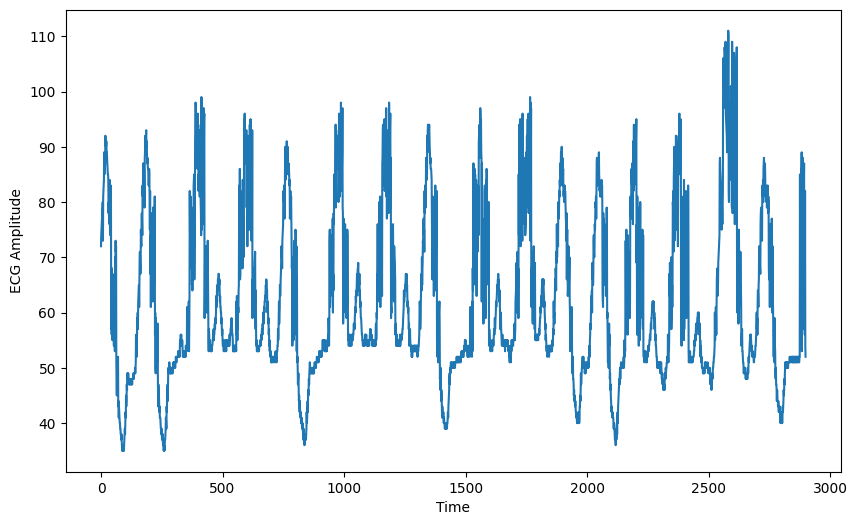

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Leer la imagen en blanco y negro
image_path = "/content/result3.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 2. Binarizar la imagen
threshold = 128
_, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

# 3. Encontrar los puntos blancos en la imagen
white_points = np.where(binary_image == 255)

# 4. Ordenar los puntos por posición (eje x) y guardar las posiciones (eje y)
x_coords = white_points[1]
y_coords = white_points[0]

sorted_indices = np.argsort(x_coords)
y_values = y_coords[sorted_indices]

# Invertir los valores en el eje Y para que coincidan con la orientación de la imagen
height, _ = image.shape
y_values_inverted = height - y_values

# Crear un vector de valores dobles con las posiciones en el eje Y
ecg_vector = y_values_inverted.astype(np.float64)

# Visualizar el vector de ECG
plt.figure(figsize=(10, 6))

plt.plot(ecg_vector)
plt.ylabel('ECG Amplitude')
plt.xlabel('Time')
plt.show()

El vector resultante está siendo distorsionado por demasiado ruido. Probamos otros filtros

### PRUEBA NÚMERO 2. Filtro1

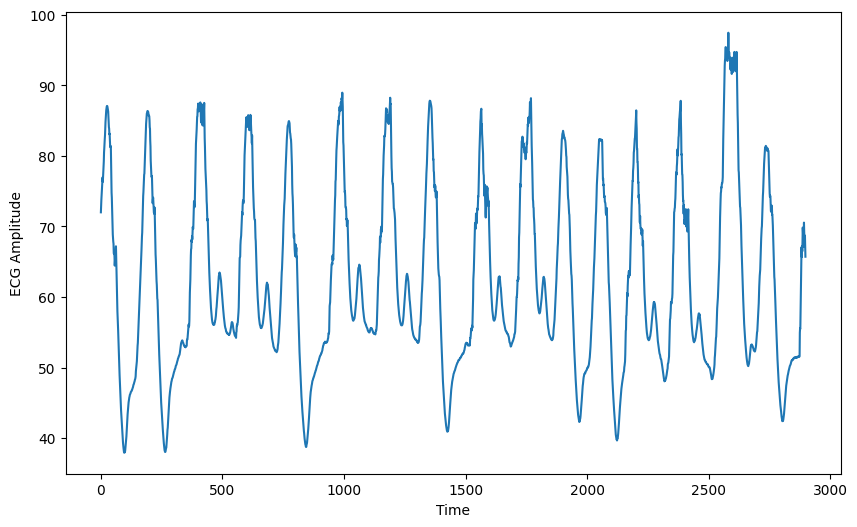

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Leer la imagen en blanco y negro
image_path = "/content/result3.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 2. Binarizar la imagen
threshold = 128
_, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

# 3. Encontrar los puntos blancos en la imagen
white_points = np.where(binary_image == 255)

# 4. Ordenar los puntos por posición (eje x) y guardar las posiciones (eje y)
x_coords = white_points[1]
y_coords = white_points[0]

sorted_indices = np.argsort(x_coords)
y_values = y_coords[sorted_indices]

# Invertir los valores en el eje Y para que coincidan con la orientación de la imagen
height, _ = image.shape
y_values_inverted = height - y_values

# Crear un vector de valores dobles con las posiciones en el eje Y
ecg_vector = y_values_inverted.astype(np.float64)

# Aplicar un filtro de media móvil exponencial para suavizar la señal
alpha = 0.1  # Ajusta el valor de alfa según la cantidad de suavizado deseado (entre 0 y 1)
smoothed_ecg_vector = pd.Series(ecg_vector).ewm(alpha=alpha).mean().values

# Visualizar el vector de ECG
plt.figure(figsize=(10, 6))

plt.plot(smoothed_ecg_vector)
plt.ylabel('ECG Amplitude')
plt.xlabel('Time')
plt.show()


Ahora si obtenemos un vector más limpio pero la onda muy modificada. Probamos otros filtros

###PRUEBA NÚMERO 3 Filtro2

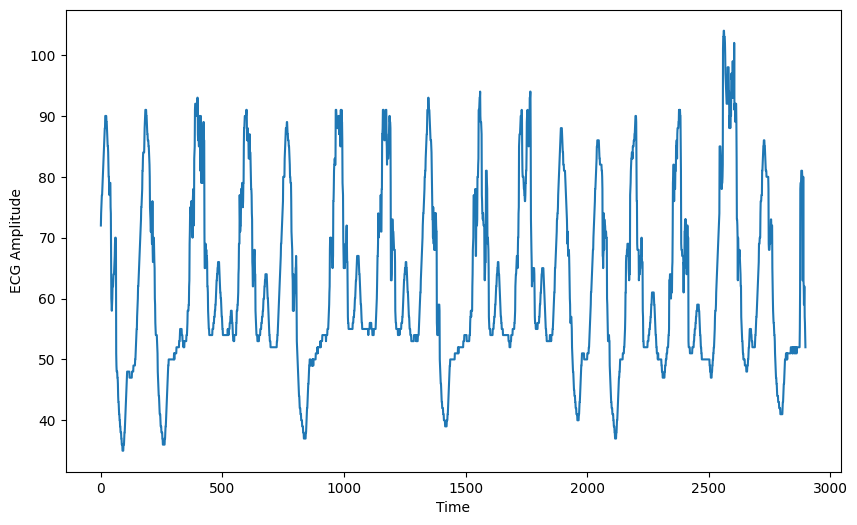

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

# 1. Leer la imagen en blanco y negro
image_path = "/content/result3.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 2. Binarizar la imagen
threshold = 128
_, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

# 3. Encontrar los puntos blancos en la imagen
white_points = np.where(binary_image == 255)

# 4. Ordenar los puntos por posición (eje x) y guardar las posiciones (eje y)
x_coords = white_points[1]
y_coords = white_points[0]

sorted_indices = np.argsort(x_coords)
y_values = y_coords[sorted_indices]

# Invertir los valores en el eje Y para que coincidan con la orientación de la imagen
height, _ = image.shape
y_values_inverted = height - y_values

# Crear un vector de valores dobles con las posiciones en el eje Y
ecg_vector = y_values_inverted.astype(np.float64)

# Aplicar un filtro de mediana móvil para suavizar la señal
window_size = 7  # Ajusta el tamaño de la ventana según la cantidad de suavizado deseado
smoothed_ecg_vector = medfilt(ecg_vector, window_size)

# Visualizar el vector de ECG
plt.figure(figsize=(10, 6))

plt.plot(smoothed_ecg_vector)
plt.ylabel('ECG Amplitude')
plt.xlabel('Time')
plt.show()


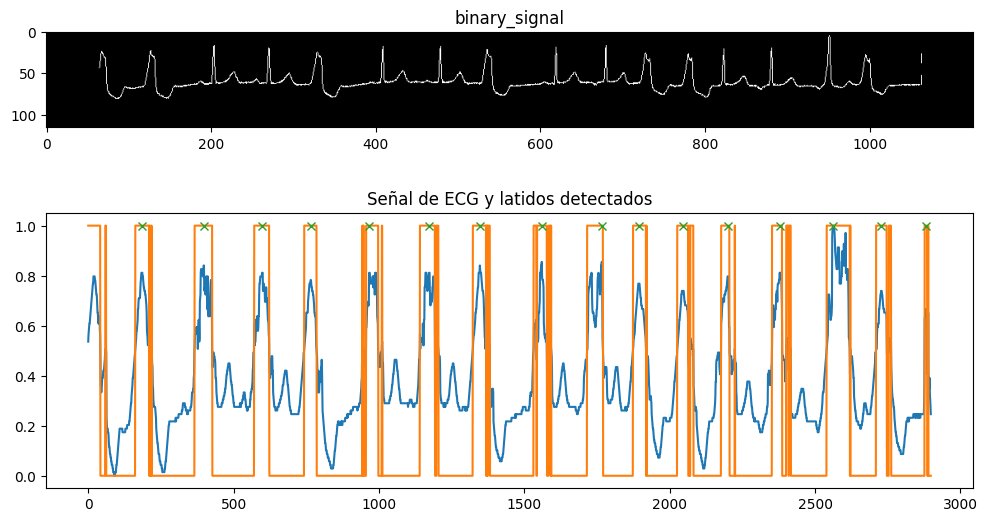

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

smoothed_ecg_vector = (smoothed_ecg_vector - np.min(smoothed_ecg_vector)) / (np.max(smoothed_ecg_vector) - np.min(smoothed_ecg_vector))

# Aplicar un umbral para identificar los latidos
threshold = 0.5
binary_signal = np.where(smoothed_ecg_vector > threshold, 1, 0)

# Estimar la separación promedio entre latidos
peaks, _ = find_peaks(smoothed_ecg_vector, height=0.5)
mean_distance = int(np.mean(np.diff(peaks)))
# Usar la función find_peaks con parámetros de height, distance y prominence para detectar latidos sin superposición
peaks, _ = find_peaks(smoothed_ecg_vector, height=threshold, distance=mean_distance, prominence=0.3)

# Visualizar los resultados
fig, ax = plt.subplots(2, 1, figsize=(10, 6))


ax[0].imshow(binary_image, cmap='gray')
ax[0].set_title("binary_signal")

ax[1].plot(smoothed_ecg_vector)
ax[1].plot(binary_signal)
ax[1].plot(peaks, binary_signal[peaks], "x")
ax[1].set_title("Señal de ECG y latidos detectados")

plt.tight_layout()
plt.show()


In [10]:
len(peaks)


16

In [66]:
import pandas as pd
signal_df = pd.DataFrame(smoothed_ecg_vector)

In [132]:
!rm -r /content/latidos


In [ ]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/saved_models/model_ecg.h5')

##2 parte preprocesado

In [75]:
!pip install wfdb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 7.7 MB/s eta 0:00:00


In [76]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import resample
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import argrelextrema

In [70]:
def record_a_vector(record):
    vector = np.squeeze(record.p_signal) # Quita las dimensiones innecesarias del array (de 2D a 1D)
    return vector

In [71]:
def grafica_vector(vector):
    plt.figure(figsize=(15, 5))
    plt.plot(vector)
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.title("Vector ECG")
    plt.grid(True)
    plt.show()

In [69]:
def remuestreo_inicial(vector_original, fs_original, fs_nueva):
    # Calcular la cantidad de muestras en el nuevo vector
    n_muestras_original = len(vector_original)
    n_muestras_nueva = int(n_muestras_original * fs_nueva / fs_original)
    # Remuestrear el vector
    vector_remuestreado = resample(vector_original, n_muestras_nueva)
    return vector_remuestreado

def normalizar_vector(vector):
    minimo = np.min(vector)
    maximo = np.max(vector)
    vector_normalizado = (vector - minimo) / (maximo - minimo)
    return vector_normalizado

def derivar_vector(vector):
    derivada = np.gradient(vector)
    return derivada

def eliminar_valores_negativos(vector):
    vector_sin_negativos = np.clip(vector, 0, None) # Los valores menores de 0 se reemplazan con 0
    return vector_sin_negativos

def media_latidos(indices):
    # Calcular las diferencias entre los índices consecutivos de los máximos
    diferencias = np.diff(indices)
    # Calcular la media de las diferencias
    media_diferencias = np.mean(diferencias)
    return media_diferencias


def comparar(a, b):
    return a > b

def encontrar_maximos(vector, umbral, distancia_minima):
    # Encontrar los índices de los máximos locales que superan el umbral
    indices_maximos = argrelextrema(vector, comparar, order=distancia_minima)
    # Filtrar los máximos locales para asegurar que superen el umbral
    indices_filtrados = [indice for indice in indices_maximos[0] if vector[indice] > umbral]
    return np.array(indices_filtrados)

def extraer_segmentos_10seg(vector, indices_maximos, media):
    segmentos = []
    ventana = int(media / 2)
    
    for indice in indices_maximos:
        inicio = indice - ventana
        fin = indice + ventana
        
        # Verificar si hay suficientes muestras a la izquierda y a la derecha del índice
        if inicio >= 0 and fin < len(vector):
            segmento = vector[inicio:fin]
            segmentos.append(segmento)
    
    return segmentos

def ajustar_longitud(segmentos, longitud_objetivo):
    segmentos_ajustados = []
    
    for segmento in segmentos:
        if len(segmento) < longitud_objetivo:
            # Rellenar con ceros si el segmento es más corto que la longitud objetivo
            segmento_ajustado = np.pad(segmento, (0, longitud_objetivo - len(segmento)), 'constant')
        else:
            # Si el segmento es más largo que la longitud objetivo, tomar los primeros 187 valores
            segmento_ajustado = segmento[:longitud_objetivo]
        
        segmentos_ajustados.append(segmento_ajustado)
            
    return segmentos_ajustados

def grafica_normalizado_latidos(vector_norm, indices):
    plt.figure(figsize=(15, 5))
    # Graficar el vector normalizado
    plt.plot(vector_norm)

    # Graficar los máximos locales encontrados
    plt.plot(indices, vector_norm[indices], 'ro')

    # Configurar la gráfica
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.title('Vector normalizado y máximos locales')

    # Mostrar la gráfica
    plt.show()


def proceso_extraccion_vector(archivo, inicio):
    #carga el archivo completo y extrae la derivación 0
    (rec, ann, longitud) = extrear_derivacion(archivo,0)

    graficar(rec, ann, inicio, inicio+10)
    
    #separa el segmento en el periodo de segundos de interes
    (rec2, ann2) = extraer_segmento(rec, ann, inicio, inicio+10)
    
    vector = record_a_vector(rec2)
    #grafica_vector(vector)
    return vector


def proceso_extraccion_vector(archivo, inicio):
    #carga el archivo completo y extrae la derivación 0
    (rec, ann, longitud) = extrear_derivacion(archivo,0)

    graficar(rec, ann, inicio, inicio+10)
    
    #separa el segmento en el periodo de segundos de interes
    (rec2, ann2) = extraer_segmento(rec, ann, inicio, inicio+10)
    
    vector = record_a_vector(rec2)
    #grafica_vector(vector)
    return vector


def proceso_segmentacion(vector, fs, umbral=0.3, distancia_minima=20, grafica=0):
    if (grafica == 1):
        print("Gráfica del vector original recibido")
        grafica_vector(vector)
    
    #ajustamos la frecuencia de muestreo
    vector_125 = remuestreo_inicial(vector, fs, 125)
    
    if (grafica == 2):
        print("Gráfica del vector ajustado a una frecuencia de 125Hz")
        grafica_vector(vector_125)
    
    #normaliza los 10 segundos
    vector_norm_orig = normalizar_vector(vector_125)
    
    if (grafica == 3):
        print("Gráfica del vector normalizado")
        grafica_vector(vector_norm_orig)
    
    #deriva el vector
    vector_der = derivar_vector(vector_125)
     
    #elimina valores negativos
    vector_sin_ceros = eliminar_valores_negativos(vector_der)
    
    #normaliza el vector
    vector_norm = normalizar_vector(vector_sin_ceros)
    
    if (grafica == 4):
        print("Gráfica del vector después de derivar, valores >0, normalizar")
        grafica_vector(vector_norm)
    
    #umbral = 0.3  # Cambia este valor según el umbral deseado
    #distancia_minima = 10  # Cambia este valor según la distancia mínima deseada entre máximos
    indices_maximos = encontrar_maximos(vector_norm, umbral, distancia_minima)
    
    #calcula la media entre latidos
    media = media_latidos(indices_maximos)
    
    #extrae segmentos en los 10 segundos
    segmentos_extraidos = extraer_segmentos_10seg(vector_norm_orig, indices_maximos, media)
    
    if (grafica == 5):
        print("Gráfica de latidos con vector derivado")
        grafica_normalizado_latidos(vector_norm_orig, indices_maximos)
    
    #ajusta longitud de los segmentos
    segmentos_ajustados = ajustar_longitud(segmentos_extraidos, 187)
    
    #genera el dataframe de salida para el modelo
    df_segmentos = pd.DataFrame(segmentos_ajustados)
    

    return df_segmentos
    

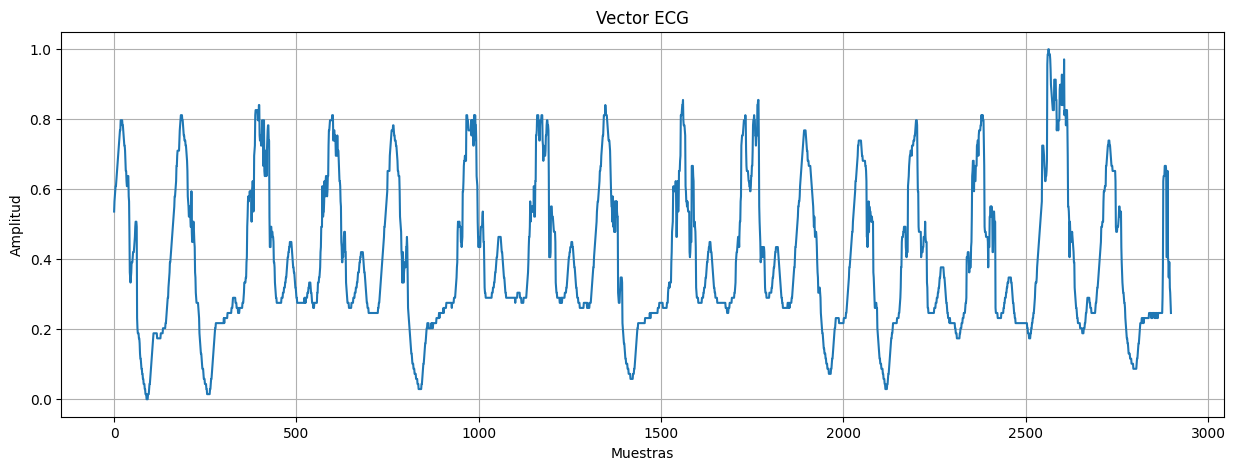

In [77]:
#carga archivos para el demo


vector7 = signal_df.to_numpy().flatten()

grafica_vector(vector7)


In [78]:
#Procesa los vectores para obtener los latidos segmentados

latidos7 = proceso_segmentacion(vector7,360)


In [99]:
def evalua(latidos):
    y_pred = modelo.predict(latidos)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(y_pred_classes)

In [96]:
#carga el modelo y evalua "latidos"
modelo = load_model('/content/drive/MyDrive/saved_models/clasificador_ver5.h5')

def evalua_y_resumen(latidos):
    y_pred = modelo.predict(latidos)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    clases = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
    conteo_clases = {key: 0 for key in clases.values()}
    
    for resultado in y_pred_classes:
        tipo_latido = clases[resultado]
        conteo_clases[tipo_latido] += 1
    
    return conteo_clases





In [100]:
evalua(latidos7)

1/1 [==============================] - 0s 41ms/step
[2 2 2 1 0 1 1 1 2]


In [97]:
resumen_latidos = evalua_y_resumen(latidos7)
for tipo, cantidad in resumen_latidos.items():
    print(f"Latidos tipo {tipo}: {cantidad}")

1/1 [==============================] - 0s 171ms/step
Latidos tipo N: 1
Latidos tipo S: 4
Latidos tipo V: 4
Latidos tipo F: 0
Latidos tipo Q: 0


In [ ]:
resumen_latidos


In [ ]:
#Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]